# Importing necessary modules and libraries

In [1]:
import os
import argparse
import math
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm, auto
from timeit import default_timer as timer
from PIL import Image
from pathlib import Path
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms, datasets
from torchvision.transforms import ToTensor, Compose, Normalize, Lambda
from torch.utils.tensorboard import SummaryWriter
from einops import repeat, rearrange
from einops.layers.torch import Rearrange
from timm.models.vision_transformer import Block
from timm.layers import trunc_normal_
from torchinfo import summary

# Checking for **Cuda**

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

# Defining Path for the dataset and exploring the subdirectories in data folder

In [3]:
image_path = Path("/kaggle/input/gsoc-6a")
mae_image_path = Path('/kaggle/input/gsoc-6a/Dataset/no_sub')
cls_image_path = Path("/kaggle/input/gsoc-6a/Dataset")

In [4]:
def explore_directory(path):
    for p, d, f in os.walk(path):
        print(f"{len(d)} directories and {len(f)} files in '{p}'")
explore_directory(image_path)

1 directories and 0 files in '/kaggle/input/gsoc-6a'
3 directories and 0 files in '/kaggle/input/gsoc-6a/Dataset'
0 directories and 29896 files in '/kaggle/input/gsoc-6a/Dataset/axion'
0 directories and 29449 files in '/kaggle/input/gsoc-6a/Dataset/no_sub'
0 directories and 29759 files in '/kaggle/input/gsoc-6a/Dataset/cdm'


In [5]:
images_path_list = list(mae_image_path.glob("*.npy"))

# Plotting random image of dataset

image shape torch.Size([1, 64, 64])
Image height: 64
Image width: 64
Image min: 0.000
Image max: 4.154


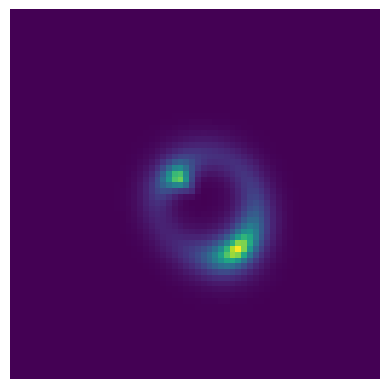

In [6]:
random_image_path = random.sample(images_path_list,1)
for img_path in random_image_path:
    img = np.load(img_path, allow_pickle=True)
    img = torch.from_numpy(img).unsqueeze(0)
    print(f"image shape {img.shape}")
    print(f"Image height: {img.shape[1]}") 
    print(f"Image width: {img.shape[2]}")
    print(f"Image min: {img.min():.3f}")
    print(f"Image max: {img.max():.3f}")

    plt.imshow(img.permute(1,2,0)) 
    plt.axis("off") 
    plt.show()

In [4]:
transform = Compose([
    ToTensor(),  
    Lambda(lambda x: x.float())])

# Creating the custom dataset pipeline

In [5]:
class dataset(Dataset):
    def __init__(self, data_path, transform=None, mae: bool = None):
        self.data_path = Path(data_path)  # Ensure data_path is a Path object
        self.transform = transform
        self.mae = mae
        if not self.mae:
            self.file_paths = list(self.data_path.rglob("*/*.npy"))
            self.labels = [path.parent.name for path in self.file_paths]
            self.classes = set(self.labels)
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
            self.idx_to_class = {i: cls_name for cls_name, i in self.class_to_idx.items()}
        else:
            self.file_paths = list(self.data_path.rglob("*.npy"))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        img = np.load(file_path, allow_pickle=True)[0] if file_path.parent.name == "axion" else np.load(file_path)
        
        if self.transform:
            img = self.transform(img)       

        if not self.mae:
            label = self.labels[idx]
            return img, self.class_to_idx[label]
        
        return img

# Loading dataset from no_sub subdirectories images for MAE

In [9]:
mae_data = dataset(data_path=mae_image_path, transform=transform, mae=True)

# Displaying random images from loaded dataset

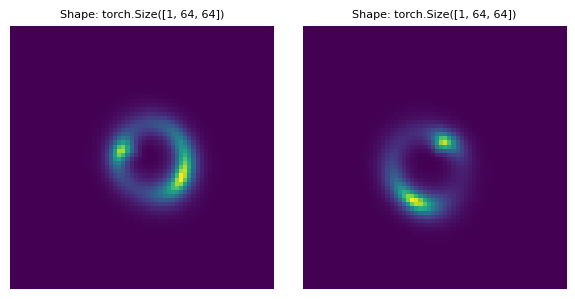

In [10]:
def display_random_images(dataset,n,seed=None):
    if n>10:
        n=10
    if seed:
        torch.manual_seed(seed)
    random_samples_idx = random.sample(range(len(dataset.file_paths)),n)
    cols = min(n,5)
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows,cols,figsize = (cols*3,rows*3))
    axes = axes.flatten() if n > 1 else [axes]

    for i, idx in enumerate(random_samples_idx):
        image = dataset[idx]
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].axis("off")
        axes[i].set_title(f"Shape: {image.shape}", fontsize=8)
    
    plt.tight_layout()

display_random_images(mae_data,2,seed=None)

# MAE Model pipeline

In [6]:
def random_indexes(size: int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

## Class to shuffle and mask the patches of input image

In [7]:
class PatchShuffle(torch.nn.Module):
    def __init__(
        self,
        ratio
    ) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches: torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))
        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]
        return patches, forward_indexes, backward_indexes

## MAE Encoder

In [8]:
class MAE_Encoder(torch.nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        emb_dim,
        num_layer,
        num_head,
        mask_ratio
    ) -> None:
        super().__init__()
        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))
        self.shuffle = PatchShuffle(mask_ratio)
        self.patchify = torch.nn.Conv2d(1, emb_dim, patch_size, patch_size)
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])
        self.layer_norm = torch.nn.LayerNorm(emb_dim)
        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches, forward_indexes, backward_indexes = self.shuffle(patches)
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        return features, backward_indexes

## MAE Decoder

In [9]:
class MAE_Decoder(torch.nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        emb_dim,
        num_layer,
        num_head
    ) -> None:
        super().__init__()
        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim))
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])
        self.head = torch.nn.Linear(emb_dim, 1 * patch_size ** 2)
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size // patch_size)
        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding
        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:]
        patches = self.head(features)
        mask = torch.zeros_like(patches)
        mask[T-1:] = 1
        mask = take_indexes(mask, backward_indexes[1:] - 1)
        img = self.patch2img(patches)
        mask = self.patch2img(mask)
        return img, mask

## ViT backbone MAE

In [10]:
class MAE_ViT(torch.nn.Module):
    def __init__(
        self,
        image_size=64,
        patch_size=16,
        emb_dim=256,
        encoder_layer=12,
        encoder_head=3,
        decoder_layer=4,
        decoder_head=3,
        mask_ratio=0.75
    ) -> None:
        super().__init__()
        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img, mask = self.decoder(features, backward_indexes)
        return predicted_img, mask

### MAE train step

In [16]:
def train_step(model, dataloader, optim, device, steps_per_update, mask_ratio, epoch, total_epoch):
    model.train()
    step_count = 0
    losses = []
    optim.zero_grad()
    for img in tqdm(iter(train_dataloader), desc=f"Epoch {epoch+1}/{total_epoch}", leave=True):
        step_count += 1
        img = img.to(device)
        predicted_img, mask = model(img)
        
        loss = torch.mean((predicted_img - img) ** 2 * mask) / mask_ratio 
        loss.backward()
        
        if step_count % steps_per_update == 0:
            optim.step()
            optim.zero_grad()
        
        losses.append(loss.item())    
    avg_loss = sum(losses) / len(losses)
    return avg_loss

### MAE evaluation step

In [17]:
def test_step(model, val_dataloader, device, mask_ratio):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch_idx, img in enumerate(val_dataloader):
            img = img.to(device)
            predicted_img, mask = model(img)            
            loss = torch.mean((predicted_img - img) ** 2 * mask) / mask_ratio
            losses.append(loss.item())
    avg_loss = sum(losses) / len(losses)
    return avg_loss

### Training function for MAE

In [18]:
def train(
    model, 
    train_dataloader, 
    val_dataloader, 
    optim, 
    lr_scheduler,
    device, 
    total_epoch,
    steps_per_update,
    mask_ratio,
    model_weight_path):
    best_val_loss = 0.0
    train_losses, test_losses = [], []
    for epoch in range(total_epoch):
        avg_loss = train_step(model=model, dataloader=train_dataloader, optim=optim, device=device, steps_per_update=steps_per_update, mask_ratio=mask_ratio, epoch=epoch ,total_epoch=total_epoch) 
        lr_scheduler.step()        
        val_loss = test_step(model=model, val_dataloader=val_dataloader, device=device, mask_ratio=mask_ratio)
        tqdm.write(f'Epoch {epoch+1}/{total_epoch} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}.')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_weight_path)
        train_losses.append(avg_loss)
        test_losses.append(val_loss)
    return train_losses, test_losses

### 90:10 split of dataset and creating train and test dataloader

In [45]:
LOAD_BATCH_SIZE = 256

# Dataset Preparation
train_size = int(0.9 * len(mae_data))
test_size = len(mae_data) - train_size
train_dataset, test_dataset = random_split(mae_data, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=LOAD_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=LOAD_BATCH_SIZE, shuffle=False)
    

# Loading MAE model

In [47]:
mae_model = MAE_ViT(image_size=64, patch_size=16, emb_dim=768, encoder_layer=12, encoder_head=3, decoder_layer=4, decoder_head=3, mask_ratio=0.75)
mae_model.to(device)

model_summary = summary(
    mae_model, 
    input_size=(256, 1, 64, 64),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"])
model_summary

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MAE_ViT (MAE_ViT)                             [256, 1, 64, 64]     [256, 1, 64, 64]     --                   True
├─MAE_Encoder (encoder)                       [256, 1, 64, 64]     [5, 256, 768]        13,056               True
│    └─Conv2d (patchify)                      [256, 1, 64, 64]     [256, 768, 4, 4]     197,376              True
│    └─PatchShuffle (shuffle)                 [16, 256, 768]       [4, 256, 768]        --                   --
│    └─Sequential (transformer)               [256, 5, 768]        [256, 5, 768]        --                   True
│    │    └─Block (0)                         [256, 5, 768]        [256, 5, 768]        7,085,568            True
│    │    └─Block (1)                         [256, 5, 768]        [256, 5, 768]        7,085,568            True
│    │    └─Block (2)                         [256, 5, 768]        [256, 5, 768]     

### Optimizer and learning rate scheduler

In [48]:
optim = torch.optim.AdamW(mae_model.parameters(), lr=1e-3, betas=(0.9, 0.95), weight_decay=0.02)

lr_func = lambda epoch: min((epoch + 1) / (10 + 1e-8), 0.5 * (math.cos(epoch / 50 * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func)

# Training MAE model

In [49]:
train_losses, test_losses = train(
    model=mae_model, 
    train_dataloader=train_dataloader, 
    val_dataloader=test_dataloader, 
    optim=optim, 
    lr_scheduler=lr_scheduler, 
    device=device, 
    total_epoch=25,
    steps_per_update=4,
    mask_ratio=0.75, 
    model_weight_path='vit-mae-wt.pth',
)

Epoch 1/25: 100%|██████████| 104/104 [00:52<00:00,  1.97it/s]


Epoch 1/25 | Train Loss: 0.1914 | Val Loss: 0.1126.


Epoch 2/25: 100%|██████████| 104/104 [00:50<00:00,  2.05it/s]


Epoch 2/25 | Train Loss: 0.1089 | Val Loss: 0.0929.


Epoch 3/25: 100%|██████████| 104/104 [00:50<00:00,  2.06it/s]


Epoch 3/25 | Train Loss: 0.0957 | Val Loss: 0.0937.


Epoch 4/25: 100%|██████████| 104/104 [00:50<00:00,  2.08it/s]


Epoch 4/25 | Train Loss: 0.1031 | Val Loss: 0.0881.


Epoch 5/25: 100%|██████████| 104/104 [00:50<00:00,  2.08it/s]


Epoch 5/25 | Train Loss: 0.0901 | Val Loss: 0.0664.


Epoch 6/25: 100%|██████████| 104/104 [00:50<00:00,  2.05it/s]


Epoch 6/25 | Train Loss: 0.0573 | Val Loss: 0.0387.


Epoch 7/25: 100%|██████████| 104/104 [00:49<00:00,  2.09it/s]


Epoch 7/25 | Train Loss: 0.0377 | Val Loss: 0.0287.


Epoch 8/25: 100%|██████████| 104/104 [00:50<00:00,  2.04it/s]


Epoch 8/25 | Train Loss: 0.0268 | Val Loss: 0.0250.


Epoch 9/25: 100%|██████████| 104/104 [00:50<00:00,  2.08it/s]


Epoch 9/25 | Train Loss: 0.0251 | Val Loss: 0.0205.


Epoch 10/25: 100%|██████████| 104/104 [00:49<00:00,  2.08it/s]


Epoch 10/25 | Train Loss: 0.0204 | Val Loss: 0.0210.


Epoch 11/25: 100%|██████████| 104/104 [00:49<00:00,  2.09it/s]


Epoch 11/25 | Train Loss: 0.0173 | Val Loss: 0.0168.


Epoch 12/25: 100%|██████████| 104/104 [00:49<00:00,  2.11it/s]


Epoch 12/25 | Train Loss: 0.0141 | Val Loss: 0.0137.


Epoch 13/25: 100%|██████████| 104/104 [00:51<00:00,  2.02it/s]


Epoch 13/25 | Train Loss: 0.0130 | Val Loss: 0.0120.


Epoch 14/25: 100%|██████████| 104/104 [00:50<00:00,  2.06it/s]


Epoch 14/25 | Train Loss: 0.0114 | Val Loss: 0.0114.


Epoch 15/25: 100%|██████████| 104/104 [00:50<00:00,  2.07it/s]


Epoch 15/25 | Train Loss: 0.0105 | Val Loss: 0.0093.


Epoch 16/25: 100%|██████████| 104/104 [00:51<00:00,  2.02it/s]


Epoch 16/25 | Train Loss: 0.0085 | Val Loss: 0.0083.


Epoch 17/25: 100%|██████████| 104/104 [00:49<00:00,  2.10it/s]


Epoch 17/25 | Train Loss: 0.0082 | Val Loss: 0.0086.


Epoch 18/25: 100%|██████████| 104/104 [00:49<00:00,  2.08it/s]


Epoch 18/25 | Train Loss: 0.0075 | Val Loss: 0.0093.


Epoch 19/25: 100%|██████████| 104/104 [00:49<00:00,  2.10it/s]


Epoch 19/25 | Train Loss: 0.0071 | Val Loss: 0.0055.


Epoch 20/25: 100%|██████████| 104/104 [00:50<00:00,  2.04it/s]


Epoch 20/25 | Train Loss: 0.0064 | Val Loss: 0.0073.


Epoch 21/25: 100%|██████████| 104/104 [00:51<00:00,  2.03it/s]


Epoch 21/25 | Train Loss: 0.0062 | Val Loss: 0.0067.


Epoch 22/25: 100%|██████████| 104/104 [00:49<00:00,  2.11it/s]


Epoch 22/25 | Train Loss: 0.0060 | Val Loss: 0.0062.


Epoch 23/25: 100%|██████████| 104/104 [00:48<00:00,  2.12it/s]


Epoch 23/25 | Train Loss: 0.0050 | Val Loss: 0.0042.


Epoch 24/25: 100%|██████████| 104/104 [00:49<00:00,  2.09it/s]


Epoch 24/25 | Train Loss: 0.0045 | Val Loss: 0.0037.


Epoch 25/25: 100%|██████████| 104/104 [00:51<00:00,  2.02it/s]


Epoch 25/25 | Train Loss: 0.0046 | Val Loss: 0.0042.


### Epoch vs Training & Validation Loss

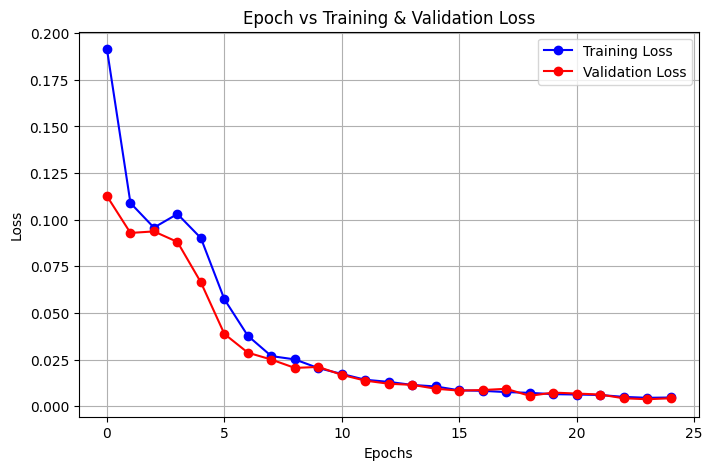

In [50]:
epochs = list(range(25))

plt.figure(figsize=(8, 5))
plt.plot(epochs[:len(train_losses)], train_losses, 'bo-', label='Training Loss')
plt.plot(epochs[:len(test_losses)], test_losses, 'ro-', label='Validation Loss') 
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()


### Visualizing masked and reconstructed images from **ViT-MAE** model

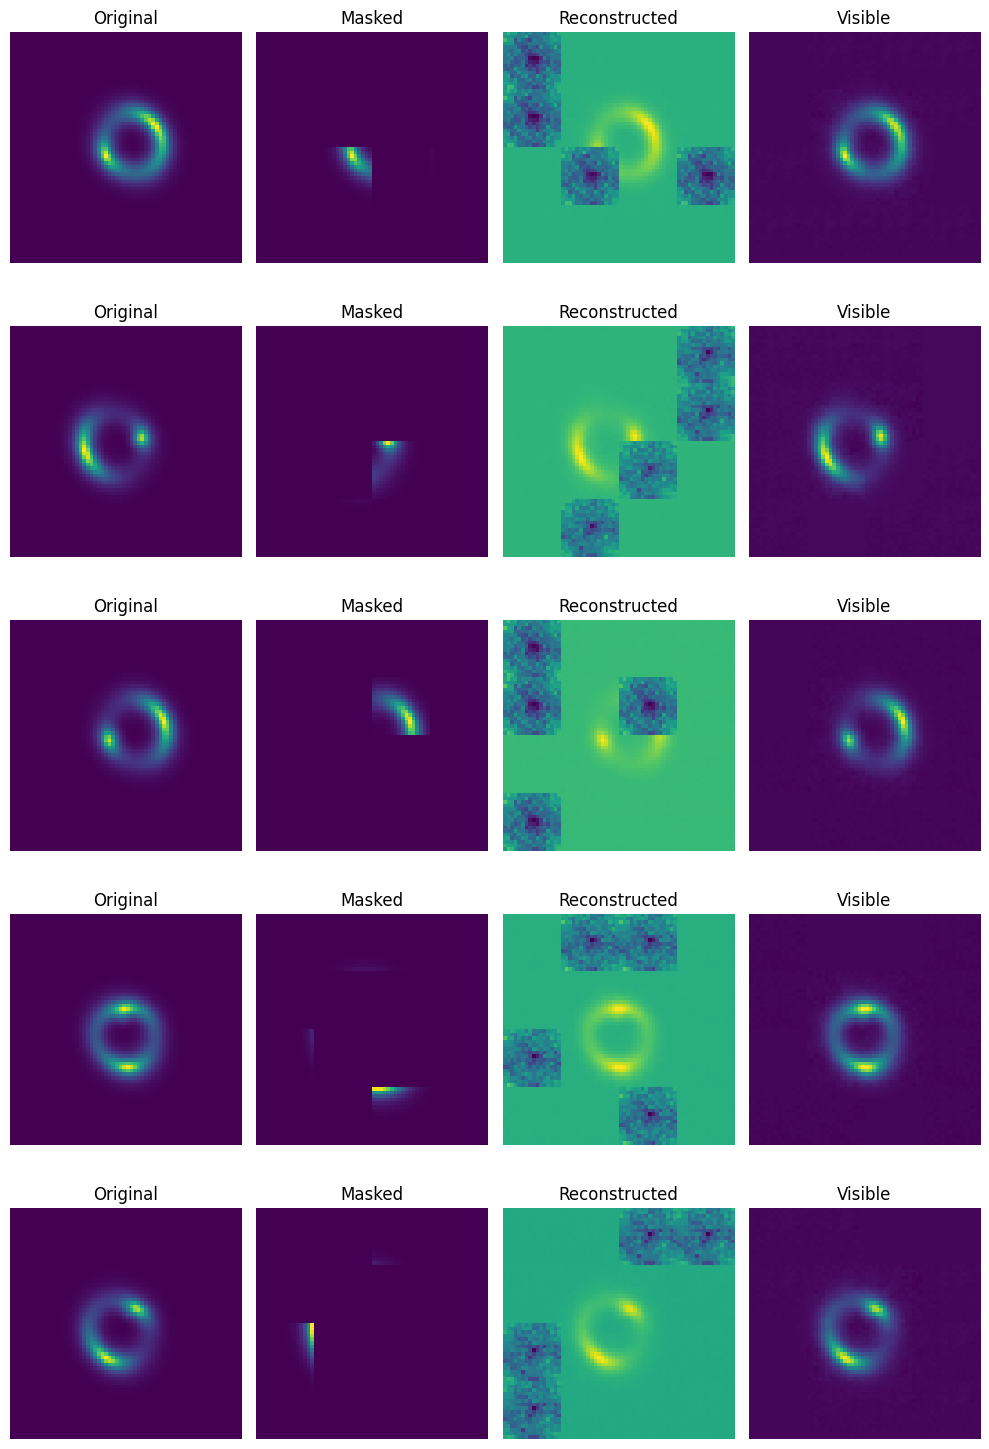

In [51]:
def visualize_reconstructions(model, num_images=5, test_dataloader=None):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in test_dataloader:
            images = batch.to(device)
            break

    reconstructed_images, masks = model(images[:num_images])

    images = images[:num_images].cpu().numpy().transpose(0, 2, 3, 1)
    reconstructed_images = reconstructed_images.detach().cpu().numpy().transpose(0, 2, 3, 1)
    masks = masks.cpu().numpy().transpose(0, 2, 3, 1)

    fig, axes = plt.subplots(num_images, 4, figsize=(10, num_images * 3))

    for i in range(num_images):
        mask = masks[i] > 0.5
        masked_image = images[i] * (1 - mask)
        visible_image = masked_image + reconstructed_images[i] * mask

        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(masked_image)
        axes[i, 1].set_title("Masked")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(reconstructed_images[i])
        axes[i, 2].set_title("Reconstructed")
        axes[i, 2].axis("off")

        axes[i, 3].imshow(visible_image)
        axes[i, 3].set_title("Visible")
        axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()

visualize_reconstructions(mae_model, num_images=5, test_dataloader=test_dataloader)


# Classifier from ViT-MAE encoder representation

In [11]:
class ViT_Classifier(torch.nn.Module):
    def __init__(self, encoder : MAE_Encoder, num_classes=10) -> None:
        super().__init__()
        self.encoder = encoder
        self.cls_token = self.encoder.cls_token
        self.pos_embedding = self.encoder.pos_embedding
        self.patchify = self.encoder.patchify
        self.transformer = self.encoder.transformer
        self.layer_norm = self.encoder.layer_norm
        self.head = torch.nn.Sequential(
                        torch.nn.Linear(self.pos_embedding.shape[-1], 64),
                        torch.nn.BatchNorm1d(64),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(0.4),
                        torch.nn.Linear(64, 3))

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits

In [12]:
def train_step_cls(
    model, 
    dataloader, 
    loss_fn, 
    acc_fn, 
    optim, 
    device,
    steps_per_update,
    epoch,
    total_epoch
):
    model.train()
    step_count = 0
    losses = []
    acces = []
    optim.zero_grad()
    
    for img, label in tqdm(iter(dataloader),desc=f"Epoch {epoch+1}/{total_epoch}", leave=True):
        step_count += 1
        img = img.to(device)
        label = label.to(device)
        
        logits = model(img)
        loss = loss_fn(logits, label)
        acc = acc_fn(logits, label)
        
        loss.backward()
        
        if step_count % steps_per_update == 0:
            optim.step()
            optim.zero_grad()
        
        losses.append(loss.item())
        acces.append(acc.item())
    
    avg_train_loss = sum(losses) / len(losses)
    avg_train_acc = sum(acces) / len(acces)
    
    return avg_train_loss, avg_train_acc

In [13]:
def validation_step_cls(
    model, 
    dataloader, 
    loss_fn, 
    acc_fn, 
    device
):
    model.eval()
    losses = []
    acces = []
    
    with torch.no_grad():
        for img, label in iter(dataloader):
            img = img.to(device)
            label = label.to(device)
            
            logits = model(img)
            loss = loss_fn(logits, label)
            acc = acc_fn(logits, label)
            
            losses.append(loss.item())
            acces.append(acc.item())
    
    avg_val_loss = sum(losses) / len(losses)
    avg_val_acc = sum(acces) / len(acces)
    
    return avg_val_loss, avg_val_acc

In [14]:
def train_cls(
    model, 
    train_dataloader, 
    val_dataloader, 
    loss_fn, 
    acc_fn, 
    optim, 
    device, 
    total_epoch, 
    steps_per_update, 
    model_weight_path,
    lr_scheduler=None     
):
    
    best_val_acc = 0
    train_loss, test_loss, train_acc, test_acc = [],[],[],[]
    lr_history = []
    for epoch in range(total_epoch):

        avg_train_loss, avg_train_acc = train_step_cls(
            model=model, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            acc_fn=acc_fn, 
            optim=optim, 
            device=device, 
            steps_per_update=steps_per_update,
            epoch=epoch,
            total_epoch=total_epoch)
        if lr_scheduler is not None:
            lr_scheduler.step()
            lr_history.append(lr_scheduler.get_last_lr()[0])
        
        # Validation step
        avg_val_loss, avg_val_acc = validation_step_cls(
            model=model, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn, 
            acc_fn=acc_fn, 
            device=device)
        tqdm.write(f"Epoch {epoch+1}/{total_epoch} | Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.3f} | "
                   f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.3f}") 
        train_loss.append( avg_train_loss)
        test_loss.append(avg_val_loss)
        train_acc.append(avg_train_acc)
        test_acc.append(avg_val_acc)

        # Model saving
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            print(f'Saving best model with acc {best_val_acc:.4f} at {epoch+1} epoch!')       
            torch.save(model.state_dict(), model_weight_path)
    return train_loss, test_loss, train_acc, test_acc, lr_history

In [15]:
cl_data = dataset(data_path=cls_image_path, transform=transform, mae=False)
cl_data.classes

{'axion', 'cdm', 'no_sub'}

In [16]:
LOAD_BATCH_SIZE = 128

# Dataset Preparation
train_size = int(0.9 * len(cl_data))
test_size = len(cl_data) - train_size
train_dataset, test_dataset = random_split(cl_data, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=LOAD_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=LOAD_BATCH_SIZE, shuffle=False)

In [17]:
loss_fn = nn.CrossEntropyLoss()
acc_fn = lambda logit, label: torch.mean((logit.argmax(dim=-1) == label).float())


## MAE based classification model 1 - **model_cls_1**
### Fine tuned only classification head

In [19]:
# Model and Optimizer Setup
model_mae1 = MAE_ViT(image_size=64,
             patch_size=16,
             emb_dim=768,
             encoder_layer=12,
             encoder_head=3,
             decoder_layer=4,
             decoder_head=3,
             mask_ratio=0.75)
model_mae1.load_state_dict(torch.load("/kaggle/input/vit-mae-wt/pytorch/default/1/vit-mae-wt.pth", weights_only=True))
model_cls_1 = ViT_Classifier(model_mae1.encoder, num_classes=3).to(device)
for param in model_cls_1.encoder.parameters():
    param.requires_grad = False

In [20]:
BASE_LR = 1e-3

optim = torch.optim.AdamW(
    model_cls_1.parameters(), 
    lr=BASE_LR,
    betas=(0.9, 0.95), 
    weight_decay=0.02)
lr_func = lambda epoch: min((epoch + 1) / (10 + 1e-8), 0.5 * (math.cos(epoch / 50 * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func)

In [21]:
train_loss_1, test_loss_1, train_acc_1, test_acc_1,_ = train_cls(
    model=model_cls_1,
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    loss_fn=loss_fn,
    acc_fn=acc_fn,
    optim=optim,
    device=device,
    total_epoch=20,
    steps_per_update=4,
    model_weight_path='vit-mae-classifier-wt.pth',
    lr_scheduler=lr_scheduler
)

Epoch 1/20: 100%|██████████| 627/627 [07:54<00:00,  1.32it/s]


Epoch 1/20 | Train Loss: 0.9652 | Train Acc: 0.537 | Val Loss: 0.7544 | Val Acc: 0.766
Saving best model with acc 0.7663 at 1 epoch!


Epoch 2/20: 100%|██████████| 627/627 [01:43<00:00,  6.04it/s]


Epoch 2/20 | Train Loss: 0.5464 | Train Acc: 0.827 | Val Loss: 0.3959 | Val Acc: 0.855
Saving best model with acc 0.8552 at 2 epoch!


Epoch 3/20: 100%|██████████| 627/627 [01:41<00:00,  6.15it/s]


Epoch 3/20 | Train Loss: 0.3663 | Train Acc: 0.869 | Val Loss: 0.2789 | Val Acc: 0.888
Saving best model with acc 0.8882 at 3 epoch!


Epoch 4/20: 100%|██████████| 627/627 [01:44<00:00,  5.98it/s]


Epoch 4/20 | Train Loss: 0.3162 | Train Acc: 0.877 | Val Loss: 0.2823 | Val Acc: 0.882


Epoch 5/20: 100%|██████████| 627/627 [01:46<00:00,  5.88it/s]


Epoch 5/20 | Train Loss: 0.2965 | Train Acc: 0.881 | Val Loss: 0.2542 | Val Acc: 0.890
Saving best model with acc 0.8897 at 5 epoch!


Epoch 6/20: 100%|██████████| 627/627 [01:44<00:00,  5.98it/s]


Epoch 6/20 | Train Loss: 0.2900 | Train Acc: 0.883 | Val Loss: 0.2769 | Val Acc: 0.884


Epoch 7/20: 100%|██████████| 627/627 [01:43<00:00,  6.03it/s]


Epoch 7/20 | Train Loss: 0.2903 | Train Acc: 0.880 | Val Loss: 0.2334 | Val Acc: 0.894
Saving best model with acc 0.8942 at 7 epoch!


Epoch 8/20: 100%|██████████| 627/627 [01:44<00:00,  6.02it/s]


Epoch 8/20 | Train Loss: 0.2909 | Train Acc: 0.880 | Val Loss: 0.2418 | Val Acc: 0.897
Saving best model with acc 0.8970 at 8 epoch!


Epoch 9/20: 100%|██████████| 627/627 [01:43<00:00,  6.05it/s]


Epoch 9/20 | Train Loss: 0.2878 | Train Acc: 0.882 | Val Loss: 0.2504 | Val Acc: 0.890


Epoch 10/20: 100%|██████████| 627/627 [01:45<00:00,  5.93it/s]


Epoch 10/20 | Train Loss: 0.2680 | Train Acc: 0.888 | Val Loss: 0.2206 | Val Acc: 0.906
Saving best model with acc 0.9056 at 10 epoch!


Epoch 11/20: 100%|██████████| 627/627 [01:44<00:00,  5.98it/s]


Epoch 11/20 | Train Loss: 0.2676 | Train Acc: 0.889 | Val Loss: 0.2283 | Val Acc: 0.901


Epoch 12/20: 100%|██████████| 627/627 [01:46<00:00,  5.89it/s]


Epoch 12/20 | Train Loss: 0.2572 | Train Acc: 0.891 | Val Loss: 0.1994 | Val Acc: 0.910
Saving best model with acc 0.9096 at 12 epoch!


Epoch 13/20: 100%|██████████| 627/627 [01:40<00:00,  6.23it/s]


Epoch 13/20 | Train Loss: 0.2438 | Train Acc: 0.898 | Val Loss: 0.1863 | Val Acc: 0.917
Saving best model with acc 0.9168 at 13 epoch!


Epoch 14/20: 100%|██████████| 627/627 [01:40<00:00,  6.23it/s]


Epoch 14/20 | Train Loss: 0.2416 | Train Acc: 0.898 | Val Loss: 0.2247 | Val Acc: 0.906


Epoch 15/20: 100%|██████████| 627/627 [01:40<00:00,  6.23it/s]


Epoch 15/20 | Train Loss: 0.2327 | Train Acc: 0.902 | Val Loss: 0.1900 | Val Acc: 0.914


Epoch 16/20: 100%|██████████| 627/627 [01:43<00:00,  6.06it/s]


Epoch 16/20 | Train Loss: 0.2307 | Train Acc: 0.902 | Val Loss: 0.2074 | Val Acc: 0.910


Epoch 17/20: 100%|██████████| 627/627 [01:39<00:00,  6.30it/s]


Epoch 17/20 | Train Loss: 0.2209 | Train Acc: 0.906 | Val Loss: 0.1891 | Val Acc: 0.913


Epoch 18/20: 100%|██████████| 627/627 [01:39<00:00,  6.32it/s]


Epoch 18/20 | Train Loss: 0.2175 | Train Acc: 0.908 | Val Loss: 0.1715 | Val Acc: 0.923
Saving best model with acc 0.9230 at 18 epoch!


Epoch 19/20: 100%|██████████| 627/627 [01:39<00:00,  6.29it/s]


Epoch 19/20 | Train Loss: 0.2120 | Train Acc: 0.909 | Val Loss: 0.1753 | Val Acc: 0.925
Saving best model with acc 0.9250 at 19 epoch!


Epoch 20/20: 100%|██████████| 627/627 [01:40<00:00,  6.24it/s]


Epoch 20/20 | Train Loss: 0.2091 | Train Acc: 0.911 | Val Loss: 0.1709 | Val Acc: 0.928
Saving best model with acc 0.9281 at 20 epoch!


In [18]:
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_training_metrics(train_loss, test_loss, train_acc, test_acc,lr_history=None):
    epochs = list(range(1, len(train_loss) + 1))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label="Train Loss", marker='o', linestyle='-')
    plt.plot(epochs, test_loss, label="Test Loss", marker='s', linestyle='--', color='r')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Epoch vs Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, label="Train Accuracy", marker='o', linestyle='-')
    plt.plot(epochs, test_acc, label="Test Accuracy", marker='s', linestyle='--', color='g')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Epoch vs Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    if lr_history is not None:
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, lr_history, label="Lr History", marker='x', linestyle='-')
        plt.xlabel("Epochs")
        plt.ylabel("Learning Rate")
        plt.title("Epoch vs Learning rate")
        plt.legend()
        plt.grid(True)
        plt.show()

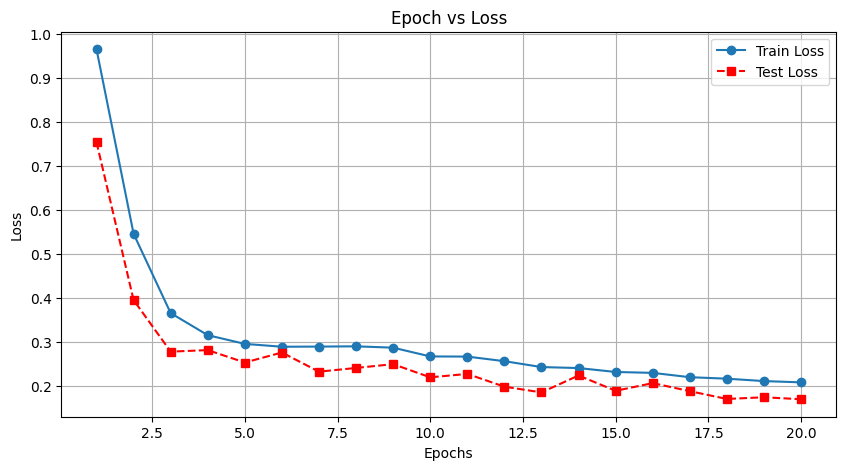

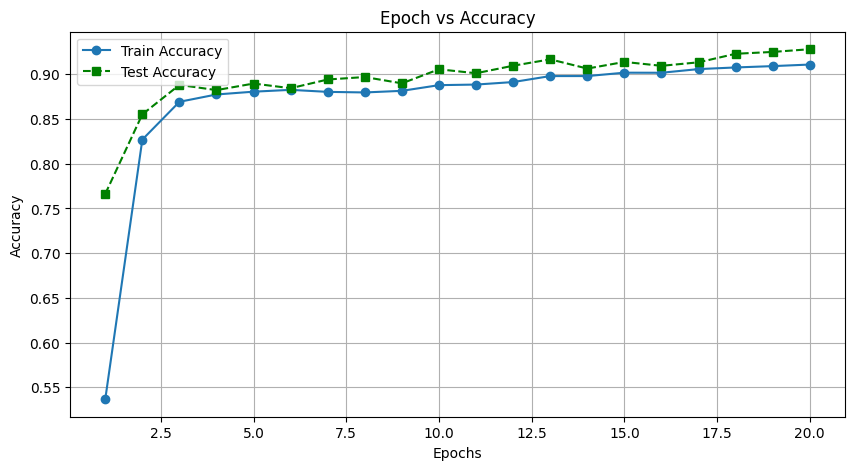

In [23]:
plot_training_metrics(train_loss_1, test_loss_1, train_acc_1, test_acc_1)

In [19]:
def compute_predictions(model, test_dataloader, num_classes=3, device="cuda"):
    model.to(device)
    model.eval()
    
    outputs = torch.empty(len(test_dataloader.dataset), num_classes, device=device)
    y_pred = torch.zeros_like(outputs)
    y_true = torch.zeros_like(outputs)
    with torch.no_grad():
        start_idx = 0
        for X, y in tqdm(test_dataloader):
            X = X.to(device)
            y = y.to(device)
            batch_size = X.shape[0]
    
            batch_outputs = model(X)
            outputs[start_idx: start_idx + batch_size] = batch_outputs    
            y_true[torch.arange(start_idx, start_idx + batch_size), y] = 1    
            start_idx += batch_size
    y_pred[torch.arange(outputs.shape[0]), torch.argmax(outputs, dim=1)] = 1  
    y_pred = y_pred.to(torch.int)
    return y_true.cpu().numpy(), y_pred.cpu().numpy()

In [25]:
y_true, y_pred = compute_predictions(model_cls_1, test_dataloader, num_classes=3, device="cuda")

100%|██████████| 70/70 [00:11<00:00,  6.05it/s]


In [20]:
def plot_confusion_matrices(y_true, y_pred, class_labels):
    fig, axes = plt.subplots(1, len(class_labels), figsize=(15, 4))

    for i, (label, ax) in enumerate(zip(class_labels, axes)):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"], ax=ax)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        ax.set_title(f"{label} (Class {i})")

    plt.tight_layout()
    plt.show()

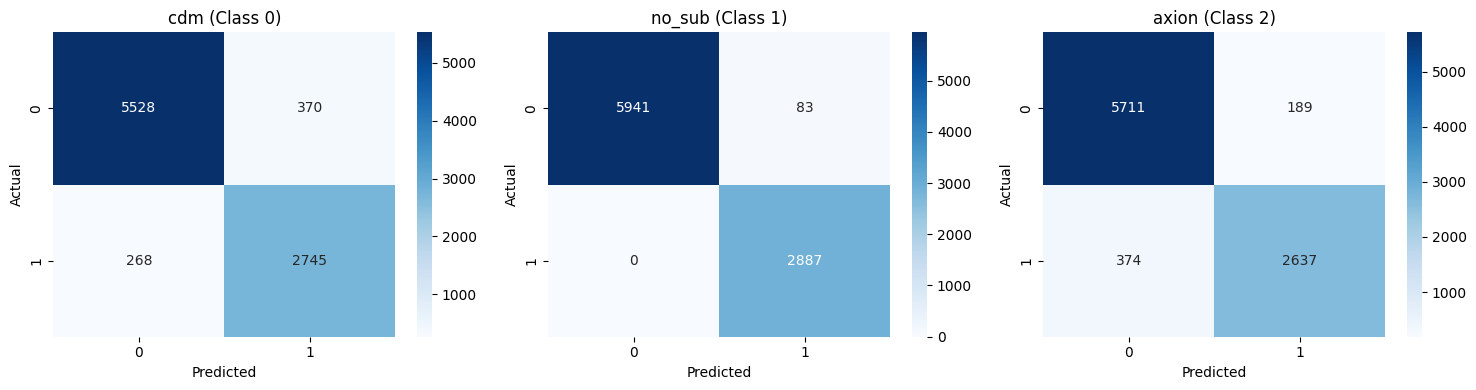

In [27]:
plot_confusion_matrices(y_true,y_pred, class_labels=cl_data.classes)

In [21]:
def plot_roc_curves(y_true_np, output_np, num_classes=3):
    plt.figure(figsize=(12, 6))

    for i in range(num_classes):
        fpr, tpr, thresholds = roc_curve(y_true_np[:, i], output_np[:, i])
        roc_auc = auc(fpr, tpr)
        
        print(f"Class {i} : AUC = {roc_auc:.2f}")
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(loc='lower right')
    plt.show()

Class 0 : AUC = 0.92
Class 1 : AUC = 0.99
Class 2 : AUC = 0.92


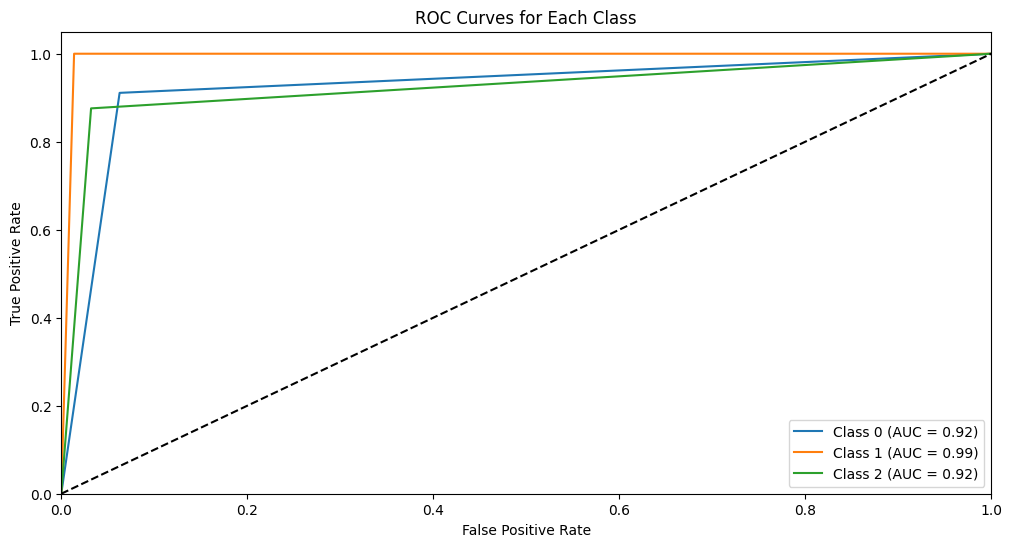

In [29]:
plot_roc_curves(y_true,y_pred, num_classes=3)

## MAE based classification model 2 - **model_cls_2**
### Fine tuned all Norm layers alongwith classification head

In [22]:
model_mae2 = MAE_ViT(image_size=64,
             patch_size=16,
             emb_dim=768,
             encoder_layer=12,
             encoder_head=3,
             decoder_layer=4,
             decoder_head=3,
             mask_ratio=0.75)
model_mae2.load_state_dict(torch.load("/kaggle/input/vit-mae-wt/pytorch/default/1/vit-mae-wt.pth", weights_only=True))
model_cls_2 = ViT_Classifier(model_mae2.encoder, num_classes=3).to(device)
for param in model_cls_2.encoder.parameters():
    param.requires_grad = False

for name, param in model_cls_2.encoder.named_parameters():
    if "norm" in name or name.startswith("layer_norm"):
        param.requires_grad = True
    

In [23]:
BASE_LR = 1e-3
optim = torch.optim.AdamW(
    model_cls_2.parameters(), 
    lr=BASE_LR,
    betas=(0.9, 0.95), 
    weight_decay=0.02)
lr_func = lambda epoch: min((epoch + 1) / (10 + 1e-8), 0.5 * (math.cos(epoch / 50 * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func)
train_loss_2, test_loss_2, train_acc_2, test_acc_2,_ = train_cls(
    model=model_cls_2,
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    loss_fn=loss_fn,
    acc_fn=acc_fn,
    optim=optim,
    device=device,
    total_epoch=20,
    steps_per_update=4,
    model_weight_path='vit-mae-classifier-wt_2.pth',
    lr_scheduler = lr_scheduler)

Epoch 1/20: 100%|██████████| 627/627 [09:05<00:00,  1.15it/s]


Epoch 1/20 | Train Loss: 0.9445 | Train Acc: 0.568 | Val Loss: 0.7471 | Val Acc: 0.759
Saving best model with acc 0.7591 at 1 epoch!


Epoch 2/20: 100%|██████████| 627/627 [02:57<00:00,  3.53it/s]


Epoch 2/20 | Train Loss: 0.5345 | Train Acc: 0.833 | Val Loss: 0.4096 | Val Acc: 0.853
Saving best model with acc 0.8535 at 2 epoch!


Epoch 3/20: 100%|██████████| 627/627 [02:20<00:00,  4.47it/s]


Epoch 3/20 | Train Loss: 0.3657 | Train Acc: 0.870 | Val Loss: 0.2971 | Val Acc: 0.881
Saving best model with acc 0.8814 at 3 epoch!


Epoch 4/20: 100%|██████████| 627/627 [02:20<00:00,  4.47it/s]


Epoch 4/20 | Train Loss: 0.3105 | Train Acc: 0.878 | Val Loss: 0.2623 | Val Acc: 0.886
Saving best model with acc 0.8862 at 4 epoch!


Epoch 5/20: 100%|██████████| 627/627 [02:18<00:00,  4.53it/s]


Epoch 5/20 | Train Loss: 0.2911 | Train Acc: 0.881 | Val Loss: 0.2715 | Val Acc: 0.884


Epoch 6/20: 100%|██████████| 627/627 [02:18<00:00,  4.53it/s]


Epoch 6/20 | Train Loss: 0.2801 | Train Acc: 0.884 | Val Loss: 0.2289 | Val Acc: 0.901
Saving best model with acc 0.9013 at 6 epoch!


Epoch 7/20: 100%|██████████| 627/627 [02:18<00:00,  4.51it/s]


Epoch 7/20 | Train Loss: 0.2696 | Train Acc: 0.889 | Val Loss: 0.2232 | Val Acc: 0.904
Saving best model with acc 0.9040 at 7 epoch!


Epoch 8/20: 100%|██████████| 627/627 [02:18<00:00,  4.54it/s]


Epoch 8/20 | Train Loss: 0.2595 | Train Acc: 0.892 | Val Loss: 0.2634 | Val Acc: 0.889


Epoch 10/20: 100%|██████████| 627/627 [02:18<00:00,  4.53it/s]


Epoch 10/20 | Train Loss: 0.2396 | Train Acc: 0.897 | Val Loss: 0.1856 | Val Acc: 0.917
Saving best model with acc 0.9166 at 10 epoch!


Epoch 11/20: 100%|██████████| 627/627 [02:20<00:00,  4.47it/s]


Epoch 11/20 | Train Loss: 0.2311 | Train Acc: 0.902 | Val Loss: 0.1763 | Val Acc: 0.925
Saving best model with acc 0.9246 at 11 epoch!


Epoch 12/20: 100%|██████████| 627/627 [02:19<00:00,  4.49it/s]


Epoch 12/20 | Train Loss: 0.2226 | Train Acc: 0.905 | Val Loss: 0.2407 | Val Acc: 0.899


Epoch 13/20: 100%|██████████| 627/627 [02:19<00:00,  4.51it/s]


Epoch 13/20 | Train Loss: 0.2135 | Train Acc: 0.908 | Val Loss: 0.1946 | Val Acc: 0.915


Epoch 14/20: 100%|██████████| 627/627 [02:21<00:00,  4.44it/s]


Epoch 14/20 | Train Loss: 0.2077 | Train Acc: 0.911 | Val Loss: 0.1682 | Val Acc: 0.922


Epoch 15/20: 100%|██████████| 627/627 [02:23<00:00,  4.38it/s]


Epoch 15/20 | Train Loss: 0.2009 | Train Acc: 0.914 | Val Loss: 0.1725 | Val Acc: 0.921


Epoch 16/20: 100%|██████████| 627/627 [02:22<00:00,  4.39it/s]


Epoch 16/20 | Train Loss: 0.1949 | Train Acc: 0.916 | Val Loss: 0.1805 | Val Acc: 0.921


Epoch 17/20: 100%|██████████| 627/627 [02:27<00:00,  4.24it/s]


Epoch 17/20 | Train Loss: 0.1898 | Train Acc: 0.918 | Val Loss: 0.1527 | Val Acc: 0.934
Saving best model with acc 0.9344 at 17 epoch!


Epoch 18/20:  24%|██▍       | 153/627 [00:33<01:48,  4.36it/s]

Epoch 18/20 | Train Loss: 0.1820 | Train Acc: 0.921 | Val Loss: 0.1493 | Val Acc: 0.934


Epoch 19/20: 100%|██████████| 627/627 [02:19<00:00,  4.50it/s]


Epoch 19/20 | Train Loss: 0.1789 | Train Acc: 0.923 | Val Loss: 0.1491 | Val Acc: 0.933


Epoch 20/20: 100%|██████████| 627/627 [02:19<00:00,  4.49it/s]


Epoch 20/20 | Train Loss: 0.1745 | Train Acc: 0.925 | Val Loss: 0.1907 | Val Acc: 0.924


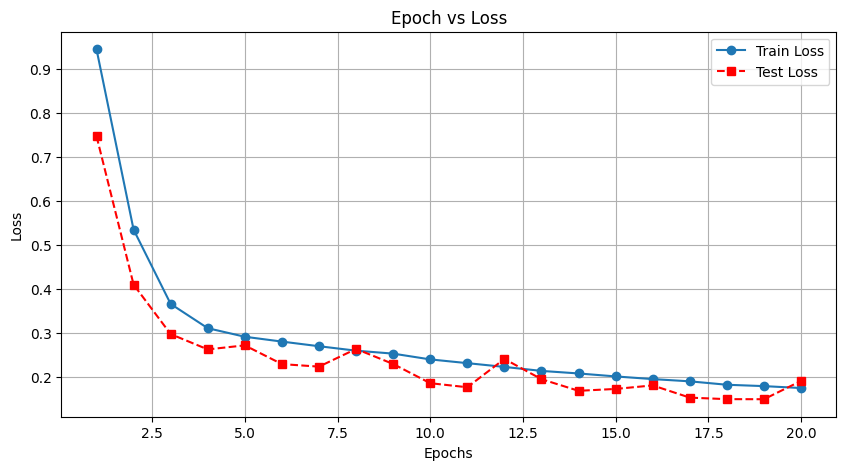

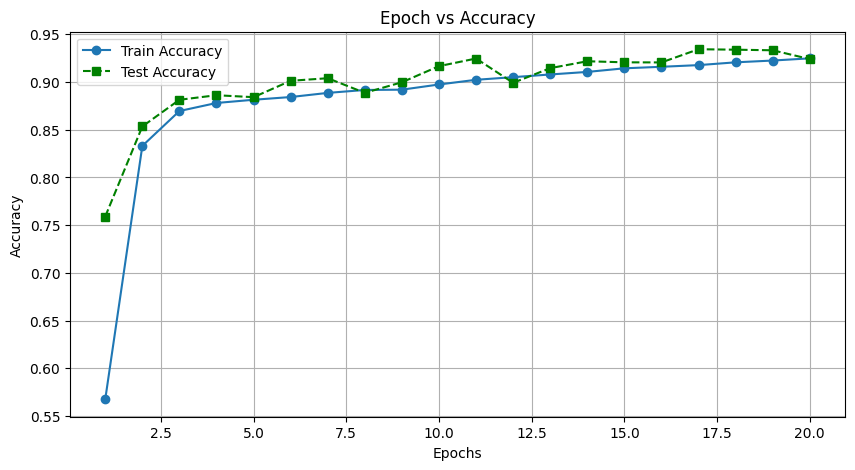

In [24]:
plot_training_metrics(train_loss_2, test_loss_2, train_acc_2, test_acc_2)

In [25]:
y_true_2, y_pred_2 = compute_predictions(model_cls_2, test_dataloader, num_classes=3, device="cuda")

100%|██████████| 70/70 [00:10<00:00,  6.46it/s]


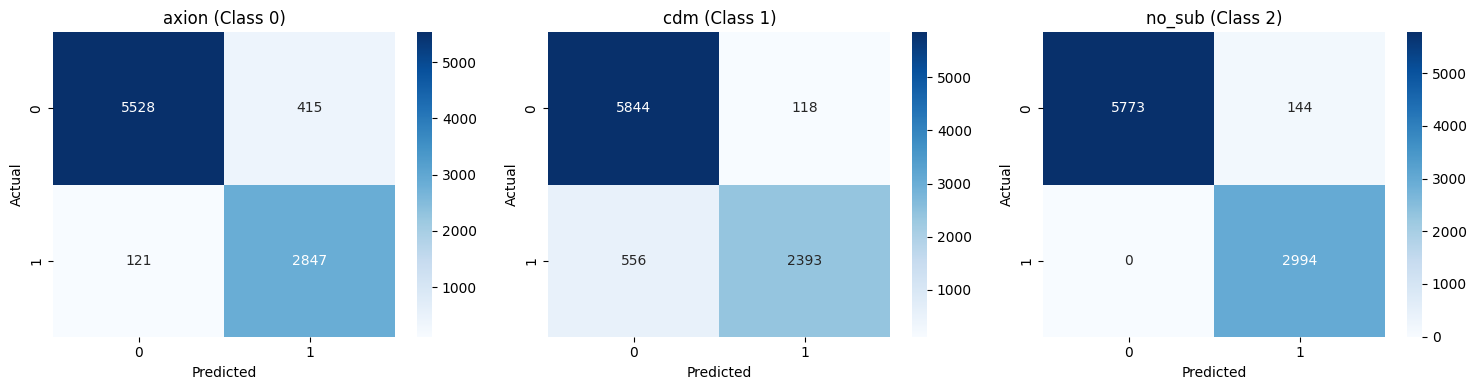

In [26]:
plot_confusion_matrices(y_true_2, y_pred_2, class_labels=cl_data.classes)

Class 0 : AUC = 0.94
Class 1 : AUC = 0.90
Class 2 : AUC = 0.99


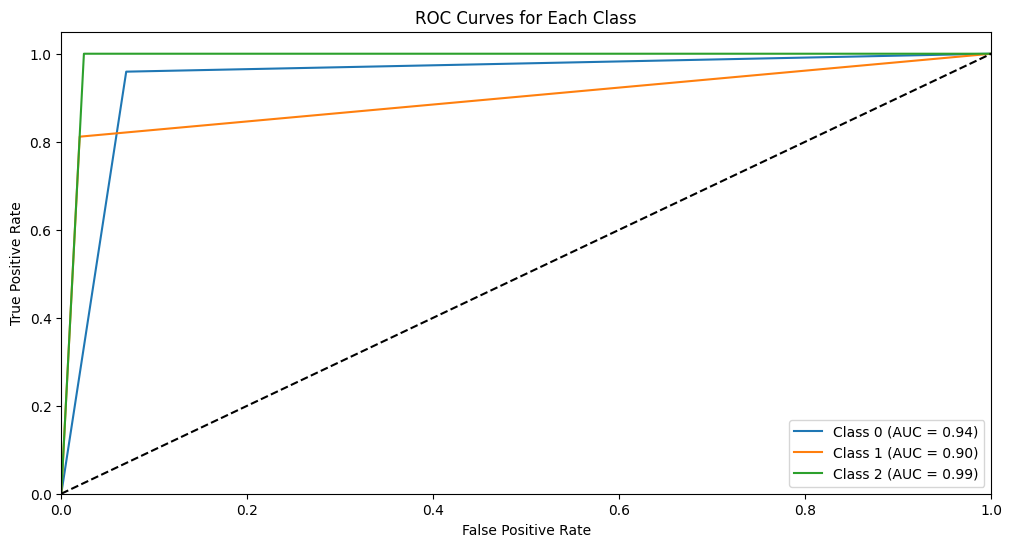

In [27]:
plot_roc_curves(y_true_2, y_pred_2, num_classes=3)

## MAE based classification model 3 - **model_cls_3**
### Fine tuned classification head along with mae encoder

In [28]:
model_mae3 = MAE_ViT(image_size=64,
             patch_size=16,
             emb_dim=768,
             encoder_layer=12,
             encoder_head=3,
             decoder_layer=4,
             decoder_head=3,
             mask_ratio=0.75)
model_mae3.load_state_dict(torch.load("/kaggle/input/vit-mae/pytorch/default/1/vit-mae-wt (2).pth", weights_only=True))
model_cls_3 = ViT_Classifier(model_mae3.encoder, num_classes=3).to(device)
for param in model_cls_3.encoder.parameters():
    param.requires_grad = True

In [29]:
BASE_LR = 5e-4
optim = torch.optim.AdamW(model_cls_3.parameters(), lr=BASE_LR, betas=(0.9, 0.95), weight_decay=0.02)

lr_func = lambda epoch: min((epoch + 1) / (10 + 1e-8), 0.5 * (math.cos(epoch / 50 * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func)

loss_fn = nn.CrossEntropyLoss()
acc_fn = lambda logit, label: torch.mean((logit.argmax(dim=-1) == label).float())

train_loss_3, test_loss_3, train_acc_3, test_acc_3, lr_history = train_cls(
    model=model_cls_3,
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    loss_fn=loss_fn,
    acc_fn=acc_fn,
    optim=optim,
    device=device,
    total_epoch=25,
    steps_per_update=4,
    model_weight_path='vit-mae-classifier-wt_3.pth',
    lr_scheduler=lr_scheduler)

Epoch 1/25: 100%|██████████| 627/627 [03:00<00:00,  3.48it/s]


Epoch 1/25 | Train Loss: 0.9086 | Train Acc: 0.542 | Val Loss: 0.6113 | Val Acc: 0.774
Saving best model with acc 0.7740 at 1 epoch!


Epoch 2/25: 100%|██████████| 627/627 [03:00<00:00,  3.48it/s]


Epoch 2/25 | Train Loss: 0.5361 | Train Acc: 0.793 | Val Loss: 0.3957 | Val Acc: 0.856
Saving best model with acc 0.8560 at 2 epoch!


Epoch 3/25: 100%|██████████| 627/627 [02:59<00:00,  3.50it/s]


Epoch 3/25 | Train Loss: 0.4495 | Train Acc: 0.826 | Val Loss: 0.4040 | Val Acc: 0.842


Epoch 4/25: 100%|██████████| 627/627 [02:58<00:00,  3.51it/s]


Epoch 4/25 | Train Loss: 0.4013 | Train Acc: 0.841 | Val Loss: 0.4080 | Val Acc: 0.833


Epoch 5/25: 100%|██████████| 627/627 [02:57<00:00,  3.53it/s]


Epoch 5/25 | Train Loss: 0.3764 | Train Acc: 0.848 | Val Loss: 0.3349 | Val Acc: 0.864
Saving best model with acc 0.8637 at 5 epoch!


Epoch 6/25: 100%|██████████| 627/627 [02:57<00:00,  3.53it/s]


Epoch 6/25 | Train Loss: 0.3688 | Train Acc: 0.851 | Val Loss: 0.5233 | Val Acc: 0.804


Epoch 7/25: 100%|██████████| 627/627 [02:58<00:00,  3.52it/s]


Epoch 7/25 | Train Loss: 0.3524 | Train Acc: 0.857 | Val Loss: 0.3071 | Val Acc: 0.869
Saving best model with acc 0.8694 at 7 epoch!


Epoch 8/25: 100%|██████████| 627/627 [02:58<00:00,  3.51it/s]


Epoch 8/25 | Train Loss: 0.3410 | Train Acc: 0.861 | Val Loss: 0.9218 | Val Acc: 0.725


Epoch 9/25: 100%|██████████| 627/627 [02:59<00:00,  3.50it/s]


Epoch 9/25 | Train Loss: 0.3392 | Train Acc: 0.861 | Val Loss: 0.2718 | Val Acc: 0.894
Saving best model with acc 0.8939 at 9 epoch!


Epoch 10/25: 100%|██████████| 627/627 [02:59<00:00,  3.50it/s]


Epoch 10/25 | Train Loss: 0.3483 | Train Acc: 0.861 | Val Loss: 0.2967 | Val Acc: 0.877


Epoch 11/25: 100%|██████████| 627/627 [02:59<00:00,  3.49it/s]


Epoch 11/25 | Train Loss: 0.3123 | Train Acc: 0.874 | Val Loss: 0.3608 | Val Acc: 0.836


Epoch 12/25: 100%|██████████| 627/627 [03:00<00:00,  3.47it/s]


Epoch 12/25 | Train Loss: 0.2932 | Train Acc: 0.880 | Val Loss: 0.3821 | Val Acc: 0.846


Epoch 13/25: 100%|██████████| 627/627 [02:57<00:00,  3.53it/s]


Epoch 13/25 | Train Loss: 0.2625 | Train Acc: 0.892 | Val Loss: 0.2959 | Val Acc: 0.867


Epoch 14/25: 100%|██████████| 627/627 [03:02<00:00,  3.43it/s]


Epoch 14/25 | Train Loss: 0.2727 | Train Acc: 0.889 | Val Loss: 0.3132 | Val Acc: 0.869


Epoch 15/25: 100%|██████████| 627/627 [03:02<00:00,  3.44it/s]


Epoch 15/25 | Train Loss: 0.2504 | Train Acc: 0.895 | Val Loss: 0.2121 | Val Acc: 0.907
Saving best model with acc 0.9069 at 15 epoch!


Epoch 16/25: 100%|██████████| 627/627 [03:00<00:00,  3.47it/s]


Epoch 16/25 | Train Loss: 0.2619 | Train Acc: 0.890 | Val Loss: 0.2355 | Val Acc: 0.907


Epoch 17/25: 100%|██████████| 627/627 [02:59<00:00,  3.50it/s]


Epoch 17/25 | Train Loss: 0.2760 | Train Acc: 0.887 | Val Loss: 0.2427 | Val Acc: 0.886


Epoch 18/25: 100%|██████████| 627/627 [02:58<00:00,  3.52it/s]


Epoch 18/25 | Train Loss: 0.2237 | Train Acc: 0.908 | Val Loss: 0.2077 | Val Acc: 0.911
Saving best model with acc 0.9108 at 18 epoch!


Epoch 19/25: 100%|██████████| 627/627 [02:59<00:00,  3.50it/s]


Epoch 19/25 | Train Loss: 0.2222 | Train Acc: 0.906 | Val Loss: 0.4843 | Val Acc: 0.856


Epoch 20/25: 100%|██████████| 627/627 [02:59<00:00,  3.49it/s]


Epoch 20/25 | Train Loss: 0.2171 | Train Acc: 0.907 | Val Loss: 0.2311 | Val Acc: 0.908


Epoch 21/25: 100%|██████████| 627/627 [02:58<00:00,  3.51it/s]


Epoch 21/25 | Train Loss: 0.2171 | Train Acc: 0.907 | Val Loss: 0.2176 | Val Acc: 0.913
Saving best model with acc 0.9126 at 21 epoch!


Epoch 22/25: 100%|██████████| 627/627 [03:03<00:00,  3.42it/s]


Epoch 22/25 | Train Loss: 0.1993 | Train Acc: 0.915 | Val Loss: 0.1787 | Val Acc: 0.928
Saving best model with acc 0.9275 at 22 epoch!


Epoch 23/25: 100%|██████████| 627/627 [02:59<00:00,  3.49it/s]


Epoch 23/25 | Train Loss: 0.2186 | Train Acc: 0.908 | Val Loss: 0.2012 | Val Acc: 0.916


Epoch 24/25: 100%|██████████| 627/627 [02:57<00:00,  3.53it/s]


Epoch 24/25 | Train Loss: 0.2131 | Train Acc: 0.910 | Val Loss: 0.1890 | Val Acc: 0.916


Epoch 25/25: 100%|██████████| 627/627 [02:57<00:00,  3.53it/s]


Epoch 25/25 | Train Loss: 0.1934 | Train Acc: 0.918 | Val Loss: 0.2918 | Val Acc: 0.861


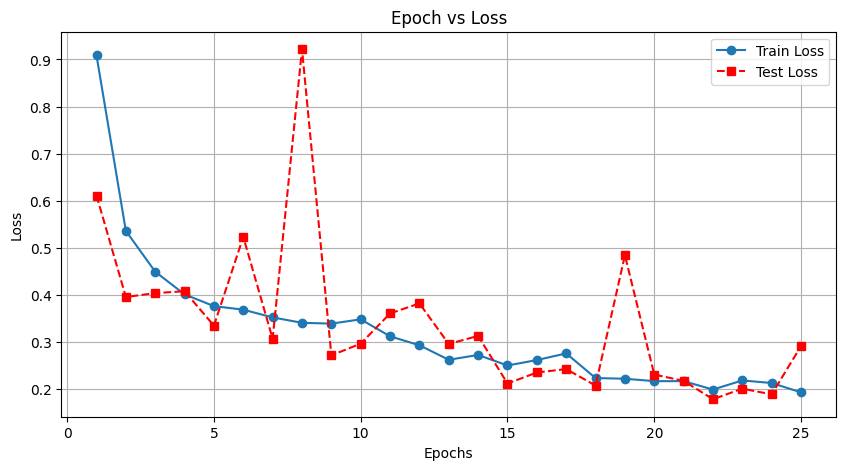

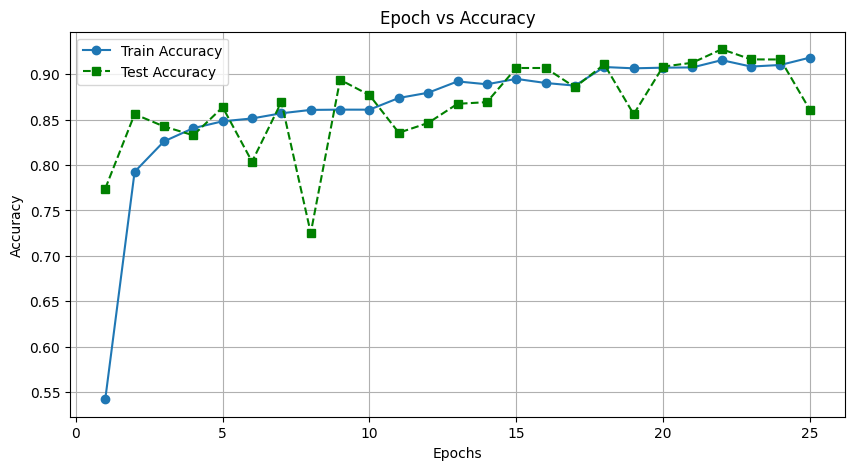

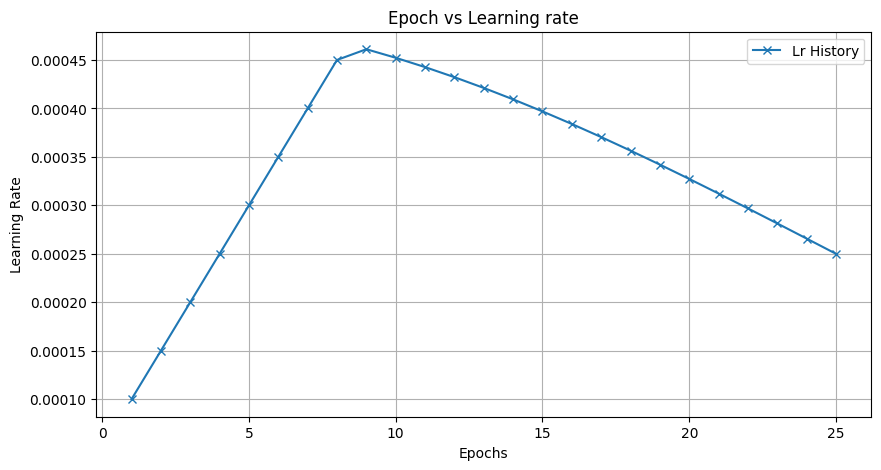

In [30]:
plot_training_metrics(train_loss_3, test_loss_3, train_acc_3, test_acc_3,lr_history)

In [31]:
y_true_3, y_pred_3 = compute_predictions(model_cls_3, test_dataloader, num_classes=3, device="cuda")

100%|██████████| 70/70 [00:10<00:00,  6.44it/s]


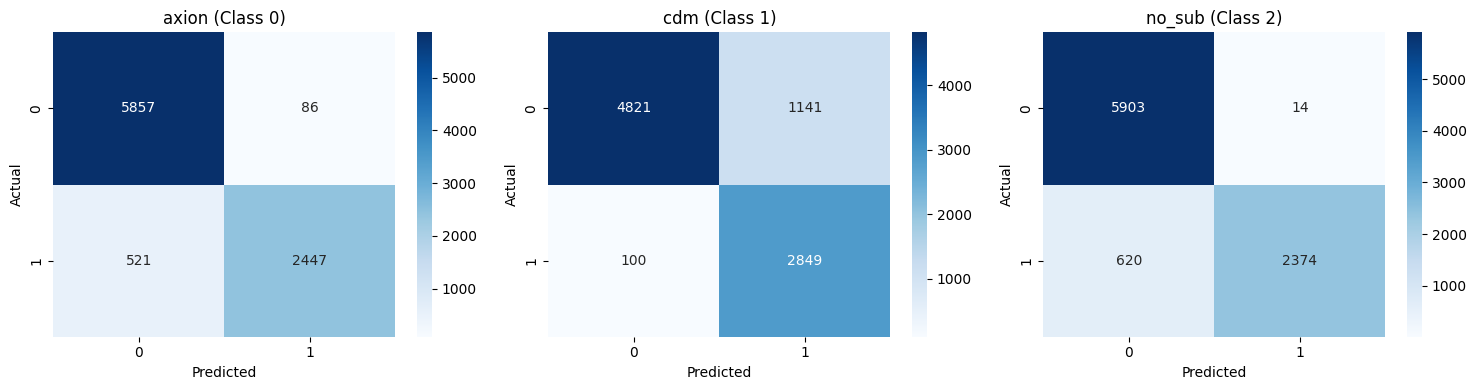

In [32]:
plot_confusion_matrices(y_true_3, y_pred_3, class_labels=cl_data.classes)

Class 0 : AUC = 0.90
Class 1 : AUC = 0.89
Class 2 : AUC = 0.90


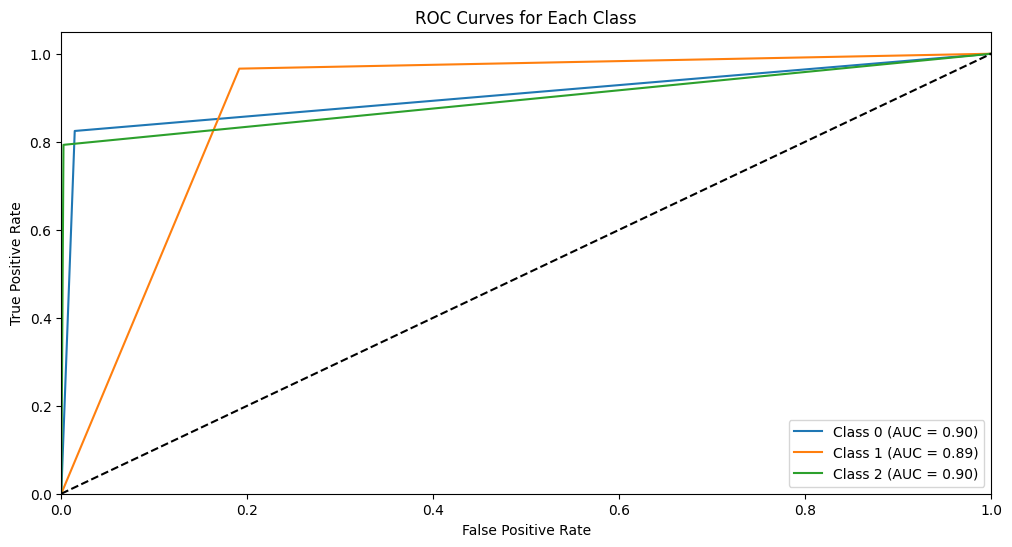

In [33]:
plot_roc_curves(y_true_3, y_pred_3, num_classes=3)